 ## **Download the images**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:

from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1f7uslI-ZHidriQFZR966_aILjlkgDN76',
dest_path='content/eye_gender_data.zip',
unzip=True)

Unzipping...Done.


## Loading Libraries

In [2]:
import pandas as pd # Data analysis and manipultion tool
import numpy as np # Fundamental package for linear algebra and multidimensional arrays
import tensorflow as tf # Deep Learning Tool
import os # OS module in Python provides a way of using operating system dependent functionality
import cv2 # Library for image processing
from sklearn.model_selection import train_test_split # For splitting the data into train and validation set
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import random
import os
from keras.preprocessing.image import ImageDataGenerator, load_img

## Loading and preparing training data

In [7]:
labels = pd.read_csv("/content/content/eye_gender_data/Training_set.csv") # loading the labels
file_paths = [[fname, '/content/content/eye_gender_data/train/' + fname] for fname in labels['filename']]
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
train_data = pd.merge(images, labels, how = 'inner', on = 'filename')

data = [] # initialize an empty numpy array
image_size = 100 # image size taken is 100 here. one can take other size too
for i in range(len(train_data)):

  img_array = cv2.imread(train_data['filepaths'][i], cv2.IMREAD_GRAYSCALE) # converting the image to gray scale

  new_img_array = cv2.resize(img_array, (image_size, image_size)) # resizing the image array
  data.append([new_img_array, train_data['label'][i]])

In [8]:
labels

,filename,label
0,Image_1.jpg,male
1,Image_2.jpg,female
2,Image_3.jpg,female
3,Image_4.jpg,female
4,Image_5.jpg,male
...,...,...
9215,Image_9216.jpg,male
9216,Image_9217.jpg,male
9217,Image_9218.jpg,male
9218,Image_9219.jpg,male


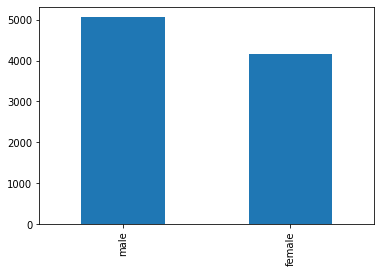

In [ ]:
labels["label"].value_counts().plot(kind='bar')

In [ ]:
sample = random.choice(labels["filename"])

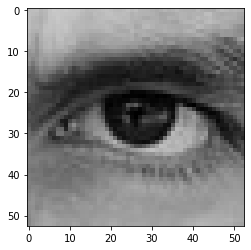

In [30]:
image = load_img("/content/content/eye_gender_data/train/Image_1.jpg")
plt.imshow(image)

In [31]:
train_df, validate_df = train_test_split(labels, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)


In [28]:
validate_df

,filename,label
0,Image_7811.jpg,male
1,Image_1181.jpg,female
2,Image_5866.jpg,male
3,Image_624.jpg,male
4,Image_712.jpg,male
...,...,...
1839,Image_4402.jpg,female
1840,Image_7482.jpg,male
1841,Image_4468.jpg,female
1842,Image_4540.jpg,male


In [32]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [33]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [34]:
def my_model():

  model = Sequential()

  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(2, activation='softmax')) # 2 because we have male and female classes

  return model

In [35]:
model = my_model()

In [36]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)       

In [37]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [38]:
earlystop = EarlyStopping(patience=10)

In [39]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [40]:
callbacks = [earlystop, learning_rate_reduction]

# Training Generator

In [41]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [42]:
total_train

7376

In [43]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/content/eye_gender_data/train", 
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 7376 validated image filenames belonging to 2 classes.


In [44]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/content/eye_gender_data/train", 
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1844 validated image filenames belonging to 2 classes.


In [45]:

example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/content/content/eye_gender_data/train", 
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


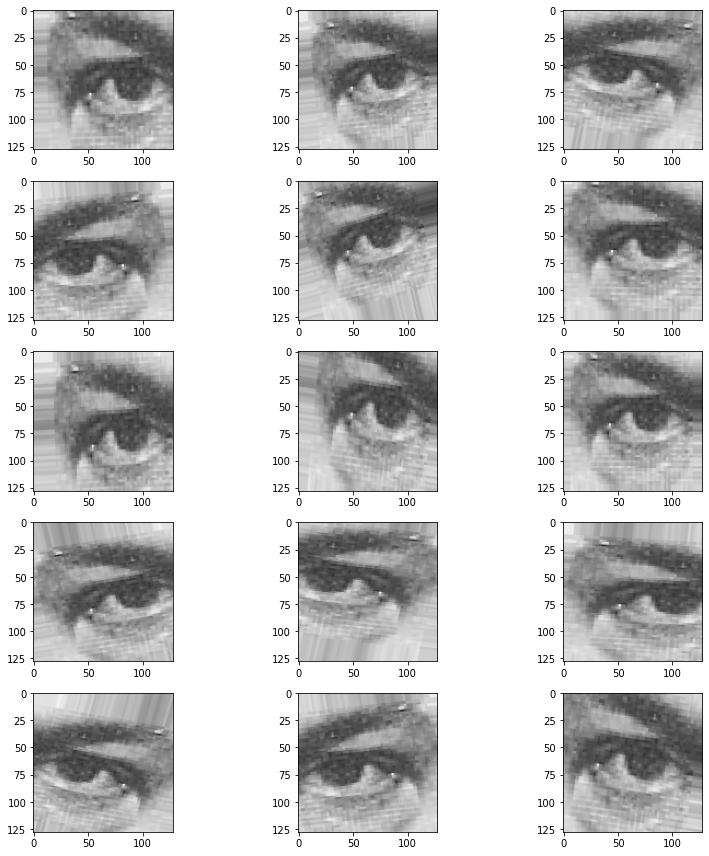

In [46]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [74]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
491/491 [==============================] - 44s 90ms/step - loss: 0.2642 - accuracy: 0.8917 - val_loss: 0.1678 - val_accuracy: 0.9432
Epoch 2/50
491/491 [==============================] - 44s 90ms/step - loss: 0.2582 - accuracy: 0.9003 - val_loss: 0.4249 - val_accuracy: 0.7798
Epoch 3/50
491/491 [==============================] - 44s 90ms/step - loss: 0.2507 - accuracy: 0.8987 - val_loss: 0.2492 - val_accuracy: 0.9022
Epoch 4/50
491/491 [==============================] - 43s 88ms/step - loss: 0.2469 - accuracy: 0.8993 - val_loss: 0.1741 - val_accuracy: 0.9355
Epoch 5/50
491/491 [==============================] - 44s 89ms/step - loss: 0.2620 - accuracy: 0.8951 - val_loss: 0.2007 - val_accuracy: 0.9257
Epoch 6/50
491/491 [==============================] - 43s 87ms/step - loss: 0.2434 - accuracy: 0.9048 - val_loss: 0.1594 - val_accuracy: 0.9410
Epoch 7/50
491/491 [==============================] - 43s 88ms/step - loss: 0.2441 - accuracy: 0.9007 - val_loss: 0.2530 - val_accuracy:

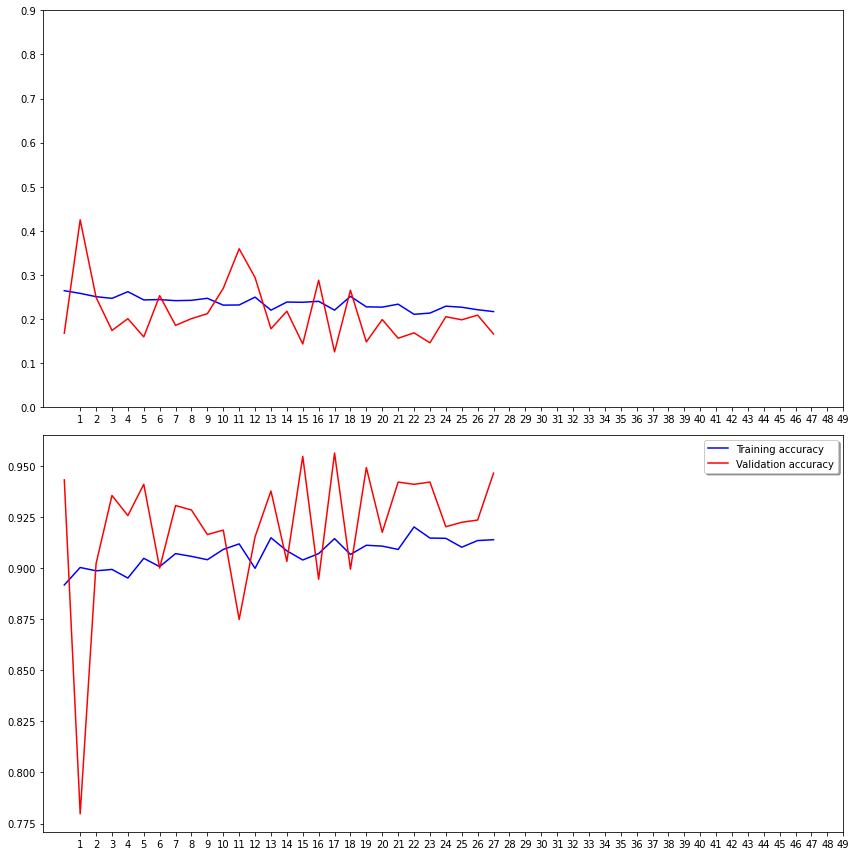

In [75]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Test Data

In [51]:
test_filenames = os.listdir("/content/content/eye_gender_data/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [52]:
nb_samples

2305

## Creating Testing Generator

In [ ]:
test_df = pd.read_csv("/content/content/eye_gender_data/Training_set.csv")

In [76]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/content/eye_gender_data/test", 
    x_col='filename',
    y_col='label',
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 2305 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 6915 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [77]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [78]:
predict

array([[0.00130614, 0.9986939 ],
       [0.30827677, 0.6917232 ],
       [0.13991635, 0.86008364],
       ...,
       [0.06104414, 0.93895584],
       [0.03057549, 0.96942455],
       [0.3019714 , 0.69802856]], dtype=float32)

In [56]:
test_df

,filename,label
0,Image_1.jpg,male
1,Image_2.jpg,female
2,Image_3.jpg,female
3,Image_4.jpg,female
4,Image_5.jpg,male
...,...,...
9215,Image_9216.jpg,male
9216,Image_9217.jpg,male
9217,Image_9218.jpg,male
9218,Image_9219.jpg,male


In [63]:
submission_df = pd.read_csv("/content/content/eye_gender_data/sample_submission.csv")
submission_df.head()

,label
0,male
1,male
2,male
3,male
4,male


In [65]:
submission_df['label'] = np.argmax(predict, axis=-1)

In [79]:
submission_df['label'] = np.argmax(predict, axis=-1)
submission_df

,label
0,1
1,1
2,1
3,1
4,1
...,...
2300,0
2301,0
2302,1
2303,1


In [66]:
submission_df

,label
0,1
1,1
2,1
3,1
4,1
...,...
2300,1
2301,0
2302,1
2303,1


In [80]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
submission_df['label'] = submission_df['label'].replace(label_map)

In [81]:
label_map

{0: 'female', 1: 'male'}

In [83]:
submission_df.to_csv("fianlAssignment01.csv",index=False)

In [82]:
submission_df

,label
0,male
1,male
2,male
3,male
4,male
...,...
2300,female
2301,female
2302,male
2303,male
